In [1]:
# Initialization
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
import numpy as np
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

In [2]:
print (hddm.__version__)

1.0.1RC


In [3]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [4]:
data_F.head(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
0,114192,2,0.984893,6,e,1,BlockFvN,1,A,2,1,2
1,114192,6,0.926056,6,e,1,BlockFvN,1,B,1,2,2
2,114192,9,0.854008,6,e,1,BlockFvN,1,B,1,2,2
3,114192,11,0.881858,6,e,1,BlockFvN,1,B,1,2,2
4,114192,12,0.918875,6,e,1,BlockFvN,1,B,1,2,2
5,114192,13,0.906791,6,e,1,BlockFvN,1,B,1,2,2
6,114192,15,0.949124,6,f,0,BlockFvN,1,A,2,1,2
7,114192,16,0.839553,6,e,1,BlockFvN,1,A,2,1,2
8,114192,17,1.006603,6,f,0,BlockFvN,1,A,2,1,2
9,114192,24,0.855258,6,f,0,BlockFvN,1,A,2,1,2


In [5]:
data_F.tail(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
9740,993849,330,0.601870,6,n,0,BlockF_1,2,B,1,2,2
9741,993849,331,0.681040,6,b,1,BlockF_1,2,A,2,1,2
9742,993849,332,0.599069,6,b,1,BlockF_1,2,B,1,2,2
9743,993849,334,0.551520,6,n,0,BlockF_1,2,A,2,1,2
9744,993849,336,0.538108,6,b,1,BlockF_1,2,B,1,2,2
9745,993849,339,0.776732,6,b,1,BlockF_1,2,A,2,1,2
9746,993849,341,0.503375,6,n,0,BlockF_1,2,A,2,1,2
9747,993849,343,0.515187,6,n,0,BlockF_1,2,B,1,2,2
9748,993849,344,0.614084,6,b,1,BlockF_1,2,A,2,1,2
9749,993849,349,0.615294,6,b,1,BlockF_1,2,B,1,2,2


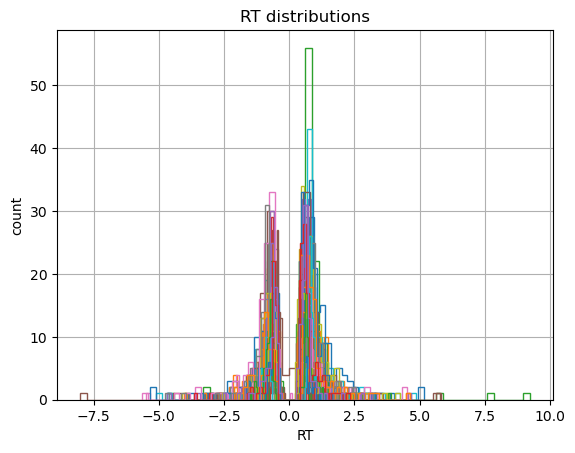

In [6]:
# Plot the RT distributions for the upper (+) and lower (-) bounds
# first flip the RT for the lower bound using flip error, i.e., the lower bound RT to make it negative
data_F = hddm.utils.flip_errors(data_F)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel = 'RT', ylabel = 'count', title = 'RT distributions')
for i, subj_data in data_F.groupby('subj_idx'):
    subj_data.rt.hist(bins = 50, histtype = 'step', ax = ax)
    
plt.savefig('./testrt.pdf')

In [7]:
# base model where all parameteres are estimated at subject level
# instantiate model object (no need to call flip_errors() before passing it).
# tailoring an individual hierarchical DDM around dataset.
m0 = hddm.HDDM(data_F, include=('z', 'v', 'a', 't'), p_outlier = 0.05, informative = False)
# find good starting point. helps with convergence
m0.find_starting_values()
# start drawing 500 samples and discarding 20 as burn-in, every 5th thinned
m0.sample(5000, burn=2500, thin = 2, dbname = './m0_traces.db', db = 'pickle')

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5001 of 5000 complete in 932.9 sechddm sampling elpased time:  933.165 s


In [8]:
m0.save('./m0_traces')

In [9]:
stats = m0.gen_stats()
m0.print_stats()

                   mean       std      2.5q       25q       50q       75q     97.5q    mc err
a              1.254125  0.026422  1.203005  1.236586   1.25443  1.272246  1.305627  0.000767
a_std          0.203748   0.02018  0.168305   0.18938  0.201732  0.217251  0.247717  0.000604
a_subj.114192    1.2831  0.058663  1.174656  1.240924  1.283367  1.324435  1.396604  0.001792
a_subj.136867  1.312846  0.050444  1.218263  1.277484  1.311729  1.347562  1.416987  0.001616
a_subj.152317  1.287635  0.053779  1.187767  1.250626  1.285108  1.322895  1.394889  0.001434
a_subj.160211  1.055012  0.044038  0.970619  1.024287  1.052298  1.084232  1.144276  0.001401
a_subj.185005  1.239279   0.05352  1.137655  1.199743  1.238655  1.275546  1.348743  0.001743
a_subj.207436  1.372572  0.076431  1.208271  1.326548  1.383096  1.424923  1.506883  0.004532
a_subj.215147  1.301338  0.051717  1.198972  1.267102  1.299502  1.335093   1.40226  0.001639
a_subj.243315  1.265562  0.048058  1.174657  1.234226  1.265

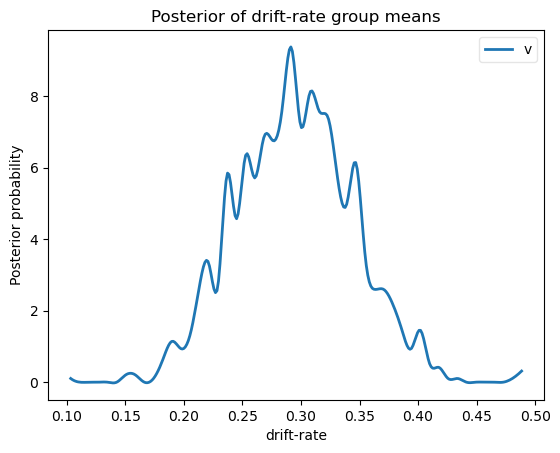

In [10]:
v = m0.nodes_db.node[['v']]
hddm.analyze.plot_posterior_nodes(v)
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('./m0.pdf', bbox_inches ="tight")

In [11]:
stats.to_csv('data.csv')